# Reconocimiento Facial - Redes Neuronales

Aplicamos una ANN para clasificar expresiones faciales y comparar con la Regresion Logistica.

Se implementa una clase ANN desde cero.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
# Solo vamos a leer 2 clases - sino usariamos getData( ).
# Los datos estan en un fichero csv con la siguiente estructura:
# - emotion - numero de 0 a 6 (0-Angry, 1-Disgust, 2-Fear, 3-Happy, 4-Sad, 5-Surprise, 6-Neutral)
# - pixels - imagen de 48 x 48 pixels (no tiene color, solo 255 tonos de grises)
# - Usage - training o test

# Devuelve un array X( ) de todos los pixels de cada imagen 
# y un vector Y( ) con las etiquetas

def getBinaryData():
    Y = []
    X = []
    first = True # para saltarnos la primera linea
    for line in open('/home/jorge/data/facial_expressions/fer2013/fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')   # separamos los datos usando la ","
            y = int(row[0])         # guardo el tipo de expresion en el target

            if y == 0 or y == 1:    # solo nos quedamos con estos tipos de expresion
                Y.append(y)
                X.append([int(p) for p in row[1].split()])
                
    return np.array(X) / 255.0, np.array(Y)        # Aqui normalizamos los datos X dividiendo por 255
                                                   # entonces nos quedan entre 0 y 1

In [3]:
def sigmoid(A):
    return 1 / (1 + np.exp(-A))

In [4]:
# Calculo de la funcion de coste con cross-entropy
def sigmoid_cost(T, Y):
    return -(T*np.log(Y) + (1-T)*np.log(1-Y)).sum()

In [5]:
def error_rate(targets, predictions):
    return np.mean(targets != predictions)

In [6]:
def relu(x):
    return x * (x > 0)

### Clase ANN

**Constructor**
La clase ANN (Artificial Neural Network) solo recibe el numero de neuronas de la única capa hidden.
 
**Metodo fit() **

Parametros de entrada
- matriz X de datos de training 
- vector Y de etiquetas 
- learning_rate 
- valor de regularizacion 
- numero de epochs 
- parametro show_fig para saber si queremos mostrar los calculos intermedios y plotearlos 
Salida: none

**Metodo forward()**

Parametros de entrada
- matriz X de datos de training 

Salida de la ANN: Y (sigmoide en este caso) y el valor de la capa hidden Z

**Metodo predict()**: solo hace el feedforward con los datos de entrada. En realidad puede verse como la P(Y|X).

Parametros de entrada
- matriz X de datos de training 

Salida de la ANN: valores de Y redondeados (para este ejemplo 0 o 1)


**Metodo score()**: calcula el scoring de un conjunto de training

Parametros de entrada
- matriz X de datos de training 
- vector Y de etiquetas

Salida: 1 - error_rate


In [7]:
class ANN(object):
    def __init__(self, M):
        self.M = M

    def fit(self, X, Y, learning_rate=5*10e-7, reg=1.0, epochs=10000, show_fig=False):
        X, Y = shuffle(X, Y)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]

        N, D = X.shape
        self.W1 = np.random.randn(D, self.M) / np.sqrt(D)
        self.b1 = np.zeros(self.M)
        self.W2 = np.random.randn(self.M) / np.sqrt(self.M)
        self.b2 = 0

        costs = []
        best_validation_error = 1
        for i in range(epochs):
            # calculamos el feedforward y el coste (podemos cambiar las funciones de activacion)
            # en la propia funcion forward()
            pY, Z = self.forward(X)

            # Hacemos el descenso de gradiente
            pY_Y = pY - Y
            self.W2 -= learning_rate*(Z.T.dot(pY_Y) + reg*self.W2)
            self.b2 -= learning_rate*((pY_Y).sum() + reg*self.b2)

            # print "(pY_Y).dot(self.W2.T) shape:", (pY_Y).dot(self.W2.T).shape
            # print "Z shape:", Z.shape
            # dZ = np.outer(pY_Y, self.W2) * (Z > 0)
            dZ = np.outer(pY_Y, self.W2) * (1 - Z*Z)
            self.W1 -= learning_rate*(X.T.dot(dZ) + reg*self.W1)
            self.b1 -= learning_rate*(np.sum(dZ, axis=0) + reg*self.b1)

            if i % 20 == 0:
                pYvalid, _ = self.forward(Xvalid)
                c = sigmoid_cost(Yvalid, pYvalid)
                costs.append(c)
                e = error_rate(Yvalid, np.round(pYvalid))
                print("i:", i, "coste:", c, "error:", e)
                if e < best_validation_error:
                    best_validation_error = e
        
        print("Mejor Error de validacion:", best_validation_error)

        if show_fig:
            plt.plot(costs)
            plt.show()


    def forward(self, X):
        # Z = relu(X.dot(self.W1) + self.b1)
        Z = np.tanh(X.dot(self.W1) + self.b1)
        return sigmoid(Z.dot(self.W2) + self.b2), Z


    def predict(self, X):
        pY = self.forward(X)
        return np.round(pY)


    def score(self, X, Y):
        prediction = self.predict(X)
        return 1 - error_rate(Y, prediction)

In [8]:
# Solo nos quedamos con 2 clases del dataset de 'Expresiones Faciales', la 0 y la 1 ((0-Angry, 1-Disgust)
X, Y = getBinaryData()

# Separamos los 2 grupos
X0 = X[Y==0, :]
X1 = X[Y==1, :]

# y vemos las cantidades de cada uno
print(X0.shape)
print(X1.shape)

(4953, 2304)
(547, 2304)


In [9]:
X1 = np.repeat(X1, 9, axis=0)
X = np.vstack([X0, X1])
Y = np.array([0]*len(X0) + [1]*len(X1))

# N, D = X.shape
# print "N:", N
# print "p(Y=0):", np.sum(Y == 0) / float(N), "p(Y=1):", np.sum(Y == 1) / float(N)
    
print(X0.shape)
print(X1.shape)
print(X.shape)

(4953, 2304)
(4923, 2304)
(9876, 2304)


In [10]:
# Instanciamos la clase ANN
model = ANN(100)

('i:', 0, 'coste:', 1200.6575318928567, 'error:', 0.46999999999999997)
('i:', 20, 'coste:', 674.5109190188814, 'error:', 0.41899999999999998)
('i:', 40, 'coste:', 661.18947803001697, 'error:', 0.40400000000000003)
('i:', 60, 'coste:', 649.46215328160929, 'error:', 0.372)
('i:', 80, 'coste:', 650.43655429942271, 'error:', 0.37)
('i:', 100, 'coste:', 672.89395202901801, 'error:', 0.41399999999999998)
('i:', 120, 'coste:', 657.24692456324192, 'error:', 0.40799999999999997)
('i:', 140, 'coste:', 646.73233310580201, 'error:', 0.40000000000000002)
('i:', 160, 'coste:', 642.68313623606332, 'error:', 0.39900000000000002)
('i:', 180, 'coste:', 640.33824802438482, 'error:', 0.39100000000000001)
('i:', 200, 'coste:', 638.26843720965326, 'error:', 0.38800000000000001)
('i:', 220, 'coste:', 636.28150738245586, 'error:', 0.38600000000000001)
('i:', 240, 'coste:', 634.38844240496667, 'error:', 0.38900000000000001)
('i:', 260, 'coste:', 632.58164957300323, 'error:', 0.38800000000000001)
('i:', 280, 'c

('i:', 2340, 'coste:', 509.5946219991979, 'error:', 0.27100000000000002)
('i:', 2360, 'coste:', 508.30728321924715, 'error:', 0.27100000000000002)
('i:', 2380, 'coste:', 507.01489506259293, 'error:', 0.27100000000000002)
('i:', 2400, 'coste:', 505.71754659833994, 'error:', 0.27100000000000002)
('i:', 2420, 'coste:', 504.41533366313877, 'error:', 0.27100000000000002)
('i:', 2440, 'coste:', 503.10835747796187, 'error:', 0.27000000000000002)
('i:', 2460, 'coste:', 501.796723112807, 'error:', 0.26700000000000002)
('i:', 2480, 'coste:', 500.48053784764141, 'error:', 0.26600000000000001)
('i:', 2500, 'coste:', 499.15990948672868, 'error:', 0.26600000000000001)
('i:', 2520, 'coste:', 497.83494469312052, 'error:', 0.26500000000000001)
('i:', 2540, 'coste:', 496.50574741874846, 'error:', 0.26300000000000001)
('i:', 2560, 'coste:', 495.17241751061738, 'error:', 0.26300000000000001)
('i:', 2580, 'coste:', 493.83504957239097, 'error:', 0.26300000000000001)
('i:', 2600, 'coste:', 492.49373215124126

('i:', 4720, 'coste:', 343.17948777740332, 'error:', 0.155)
('i:', 4740, 'coste:', 341.86858725934121, 'error:', 0.153)
('i:', 4760, 'coste:', 340.56299531444751, 'error:', 0.153)
('i:', 4780, 'coste:', 339.2628206146963, 'error:', 0.151)
('i:', 4800, 'coste:', 337.96816782552526, 'error:', 0.14899999999999999)
('i:', 4820, 'coste:', 336.67913717017314, 'error:', 0.14899999999999999)
('i:', 4840, 'coste:', 335.39582401262129, 'error:', 0.14799999999999999)
('i:', 4860, 'coste:', 334.11831846860684, 'error:', 0.14799999999999999)
('i:', 4880, 'coste:', 332.84670505396883, 'error:', 0.14699999999999999)
('i:', 4900, 'coste:', 331.58106237877632, 'error:', 0.14699999999999999)
('i:', 4920, 'coste:', 330.32146289432865, 'error:', 0.14699999999999999)
('i:', 4940, 'coste:', 329.06797269832146, 'error:', 0.14699999999999999)
('i:', 4960, 'coste:', 327.82065140146562, 'error:', 0.14699999999999999)
('i:', 4980, 'coste:', 326.57955205671908, 'error:', 0.14599999999999999)
('i:', 5000, 'coste:'

('i:', 7240, 'coste:', 222.01887729405104, 'error:', 0.089999999999999997)
('i:', 7260, 'coste:', 221.56565631467967, 'error:', 0.089999999999999997)
('i:', 7280, 'coste:', 221.81882688803952, 'error:', 0.089999999999999997)
('i:', 7300, 'coste:', 216.37610266060716, 'error:', 0.085999999999999993)
('i:', 7320, 'coste:', 231.16297145976091, 'error:', 0.096000000000000002)
('i:', 7340, 'coste:', 191.08081343363307, 'error:', 0.070000000000000007)
('i:', 7360, 'coste:', 271.60241049455988, 'error:', 0.122)
('i:', 7380, 'coste:', 163.72293205425672, 'error:', 0.052999999999999999)
('i:', 7400, 'coste:', 155.9424904688276, 'error:', 0.050999999999999997)
('i:', 7420, 'coste:', 153.40670589868176, 'error:', 0.049000000000000002)
('i:', 7440, 'coste:', 152.67632080961863, 'error:', 0.050999999999999997)
('i:', 7460, 'coste:', 2294.1617856517778, 'error:', 0.45500000000000002)
('i:', 7480, 'coste:', 161.63556858197563, 'error:', 0.048000000000000001)
('i:', 7500, 'coste:', 154.48680604347433,

('i:', 9520, 'coste:', 123.11729633852354, 'error:', 0.041000000000000002)
('i:', 9540, 'coste:', 120.20230498811929, 'error:', 0.039)
('i:', 9560, 'coste:', 139.85999494571124, 'error:', 0.041000000000000002)
('i:', 9580, 'coste:', 154.23268977022252, 'error:', 0.050000000000000003)
('i:', 9600, 'coste:', 129.68225465501672, 'error:', 0.043999999999999997)
('i:', 9620, 'coste:', 125.95538566846527, 'error:', 0.043999999999999997)
('i:', 9640, 'coste:', 123.7945058311057, 'error:', 0.044999999999999998)
('i:', 9660, 'coste:', 122.57576416732047, 'error:', 0.042000000000000003)
('i:', 9680, 'coste:', 121.88784789449011, 'error:', 0.041000000000000002)
('i:', 9700, 'coste:', 121.42334898155374, 'error:', 0.041000000000000002)
('i:', 9720, 'coste:', 121.06355231427321, 'error:', 0.041000000000000002)
('i:', 9740, 'coste:', 120.75974456555291, 'error:', 0.041000000000000002)
('i:', 9760, 'coste:', 120.48843521759591, 'error:', 0.041000000000000002)
('i:', 9780, 'coste:', 120.23667604530067

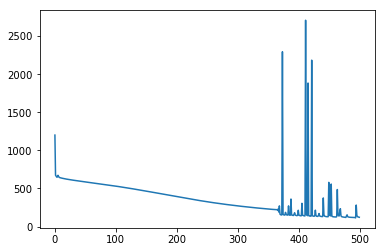

In [11]:
# Entrenamos con los datos pre-procesados
# En este caso usamos el numero de epochs que hemos definido por defecto en la clase ANN
# Tambien por defecto los valores de learning_rate y regularizacion.
model.fit(X, Y, show_fig=True)

Puede verse que en el caso de la ANN el mejor error de validación es aún mejor que el caso de Regresion Logistica.

El ejemplo de Regresion Logistica (Básico), nos dio un error de validación de 0.87 con 120.000 epochs y en este caso ha sido 0.034 con 10.000 epochs.

